In [ ]:
!apt-get -qq install -y graphviz && pip install pydot
import pydot
# Install required libraries
!pip install requests pandas numpy tqdm pyod matplotlib seaborn openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=0374488bceb944732edf0996569be68652ccbff811e71d58d0996e49a812c0aa
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [ ]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.abod import ABOD
import matplotlib.pyplot as plt
import seaborn as sns

# курс обмена
currency_dict = {
    'EUR': 98.87,
    'USD': 89.20
}

# функция для выборки с url
def fetch_jobs(url, total_requests):
    jobs = []
    for page in range(total_requests):  # 2000 запросов
        response = requests.get(f"{url}&page={page}")  # включает параметр пагинации
        if response.status_code == 200:
            jobs.extend(response.json()['items'])
        else:
            print(f"Error fetching data from {url}: {response.status_code}")

    return jobs

In [ ]:
# сбор информации по двум типам вакансий
url_developer = 'https://api.hh.ru/vacancies?text=разработчик&only_with_salary=true&per_page=100'
url_python_developer = 'https://api.hh.ru/vacancies?text=разработчик_на_питоне&only_with_salary=true&per_page=100'

# total_requests - запрос на 2000 вакансий (20 страниц по 100 вакансий)
total_requests = 20

jobs = []
jobs.extend(fetch_jobs(url_developer, total_requests))
jobs.extend(fetch_jobs(url_python_developer, total_requests))

# вывод информации о зарплатах
def extract_salary(job):
    salary = job.get('salary', {})
    from_salary = salary.get('from', 0)
    to_salary = salary.get('to', 0)
    currency = salary.get('currency', 'RUR')

    if from_salary and to_salary:
        avg_salary = (from_salary + to_salary) / 2
    elif from_salary:
        avg_salary = from_salary
    elif to_salary:
        avg_salary = to_salary
    else:
        avg_salary = 0

    # вычет налогов
    if salary.get('gross', False):
        avg_salary *= 0.87

    # конвертация в рубли
    if currency != 'RUR' and currency in currency_dict:
        avg_salary *= currency_dict[currency]

    return avg_salary

# Обработка данных
data = []
for job in tqdm(jobs):
    job_data = {
        'id': job.get('id'),
        'name': job.get('name'),
        'area.name': job.get('area', {}).get('name'),
        'salary': extract_salary(job),
        'snippet.requirements': job.get('snippet', {}).get('requirements', ''),
        'experience.name': job.get('experience', {}).get('name', '')
    }
    data.append(job_data)

df = pd.DataFrame(data)
print(df)

100%|██████████| 2000/2000 [00:00<00:00, 173050.19it/s]

             id                                               name area.name  \
0     106664286                        Junior Frontend Разработчик    Бишкек   
1     108453823                           Python Backend Developer    Астана   
2     108742825       Frontend разработчик (Phoenix IT Consulting)   Ташкент   
3     107759001                                 Стажер-разработчик    Алматы   
4     108687926                       JavaScript/React разработчик    Алматы   
...         ...                                                ...       ...   
1995  105796302                              Программист-стажер 1С      Тула   
1996  107688380                      Исполнительный директор (CEO)     Пермь   
1997  107844651                 Фронтент разработчик, верстальшик.   Ташкент   
1998  107853687  Администратор сайта / Контент менеджер/ маркет...    Москва   
1999  108032263                                 Sales Professional    Москва   

         salary snippet.requirements   

Text(0.5, 1.0, 'Гистограмма зарплат для всех вакансий')

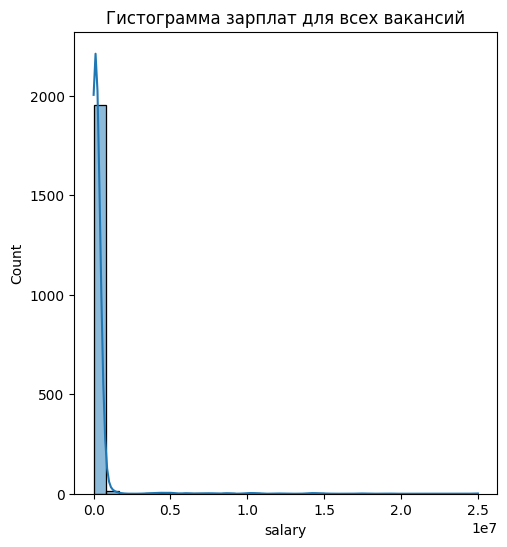

In [ ]:
# Визуализация зарплат
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['salary'], bins=30, kde=True)
plt.title('Гистограмма зарплат для всех вакансий')

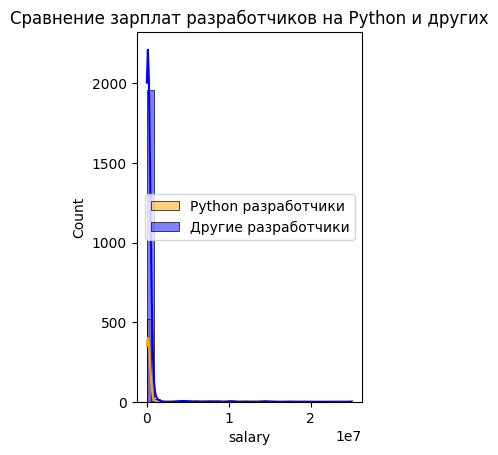

In [ ]:
plt.subplot(1, 2, 2)
sns.histplot(df[df['name'].str.contains("разработчик", case=False)]['salary'], bins=30, kde=True, color='orange', label='Python разработчики')
sns.histplot(df[~df['name'].str.contains("разработчик на питон", case=False)]['salary'], bins=30, kde=True, color='blue', label='Другие разработчики')
plt.title('Сравнение зарплат разработчиков на Python и других')
plt.legend()
plt.show()

In [ ]:
# создание и очистка колонки с зарплатами
df['clean_sal'] = df['salary']

# Detect anomalies using PyOD
models = [KNN(), IForest(), ABOD()]
for model in models:
    model.fit(df[['clean_sal']])
    df[f'anomaly_{model.__class__.__name__}'] = model.labels_

# Выборка для окончательного определения аномалий
df['anomaly'] = df[[f'anomaly_{model.__class__.__name__}' for model in models]].sum(axis=1)
df['anomaly'] = np.where(df['anomaly'] >= 2, 1, 0)  # Определение аномалий, основанное на выборке

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encoun

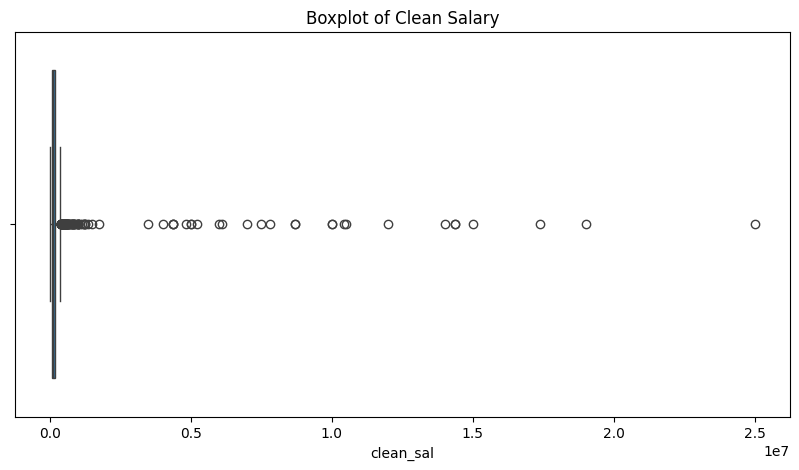

In [ ]:
# Визуализация аномалий в boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['clean_sal'])
plt.title('Boxplot of Clean Salary')
plt.show()

In [ ]:
# Generate explanations based on conditions
def generate_explanations(row):
    if row['anomaly'] == 1:
        return "Обнаружена аномалия по диапазону зарплат."
    else:
        return "Нормальный диапазон зарплат."

df['explanation'] = df.apply(generate_explanations, axis=1)
print(df)

             id                                               name area.name  \
0     106664286                        Junior Frontend Разработчик    Бишкек   
1     108453823                           Python Backend Developer    Астана   
2     108742825       Frontend разработчик (Phoenix IT Consulting)   Ташкент   
3     107759001                                 Стажер-разработчик    Алматы   
4     108687926                       JavaScript/React разработчик    Алматы   
...         ...                                                ...       ...   
1995  105796302                              Программист-стажер 1С      Тула   
1996  107688380                      Исполнительный директор (CEO)     Пермь   
1997  107844651                 Фронтент разработчик, верстальшик.   Ташкент   
1998  107853687  Администратор сайта / Контент менеджер/ маркет...    Москва   
1999  108032263                                 Sales Professional    Москва   

         salary snippet.requirements   

In [ ]:
# Save to Excel
output_file = 'job_vacancies_with_anomalies.xlsx'
df.to_excel(output_file, index=False)

# print(f'Results saved to {output_file}')

In [ ]:
import zipfile

# Создание ZIP-архива
with zipfile.ZipFile('job_vacancies.zip', 'w') as zipf:
    zipf.write(output_file)

print('Создан ZIP-архив job_vacancies.zip')

# Загрузить ZIP-архив
#ZipFile.download('job_vacancies.zip')

Создан ZIP-архив job_vacancies.zip
